*Outlier*
- 특정 기준에서 보았을때, 값이 너무 작거나 큰 경우 이를 이상치로 판단할 수 있음
- 보통 이상치를 어떠한 값으로 대체하거나 제거하는 방식을 택함
- 이상치를 제거하는 경우 모든 변수들의 이상치를 제거하는 것은 효율적이지 못함 (너무 많은 데이터의 손실, 중요한 변수가 아닐 경우 성능에 유의미한 영향 X)
- 예측하고자하는 라벨값과의 비교를 통해 상관관계가 높은 변수의 이상치를 제거하는 방식이 합리적임 - 상관관계 이외에 Feature Importance도 고려하면 좋을듯함

> 사용 데이터
> - 서울시 따릉이 이용자수 데이터 - 데이터 설명: [링크](https://dacon.io/competitions/open/235576/data)


|변수|설명|
|--|--|
|id|고유 id|
|hour| 시간  |
|temperature |기온  |
|precipitation| 비가 오지 않았으면 0, 비가 오면 1  |
|windspeed| 풍속(평균)  |
|humidity |습도  |
|visibility| 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미) | 
|ozone| 오존 | 
|pm10| 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)  |
|pm2.5| 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)  |
|count| 시간에 따른 따릉이 대여 수|

## 통계적  수치를 활용
- 가장 먼저 시도해 볼 수 있는 방법으로 각종 통계량을 사용하여 이상치를 제거하는 방식(ex) 사분위수, 5%미만, 95% 이상)
- 간단하게 시도해 볼 수 있는 상황이지만 이상치에 의해 통계값에 오류가 있을 수 있음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Waeing
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

# score
from sklearn.model_selection import train_test_split

# permutation importance
import eli5 
from eli5.sklearn import PermutationImportance    

# 상관관계 시각화
import seaborn as sns #EDA

# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#matplotlib 한글깨짐 지원
import platform
from matplotlib import font_manager, rc
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

- 데이터 불러오기

In [2]:
# 데이터 불러오기
path = './datasets/따릉이/'
train = pd.read_csv(path+'train.csv').drop(columns='count',axis=0)
train_y = pd.read_csv(path+'train.csv')['count']
test = pd.read_csv(path+'test.csv')

In [3]:
train

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0
...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


In [4]:
# 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 114.1 KB


In [5]:
# 간단한 결측값 처리 - 평균값으로 채움
columns = list(train.columns[2:])
for col in columns:
    ## train
    train[col] = train[col].fillna(train[col].mean())
    ## test
    test[col] = test[col].fillna(test[col].mean())

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 114.1 KB


- 상관관계가 높은 변수의 이상치를 제거하기 위하여 상관관계를 시각화로 확인 - 결과적으로 hour 변수가 상관관계가 가장 높다는 것을 확인

<AxesSubplot:>

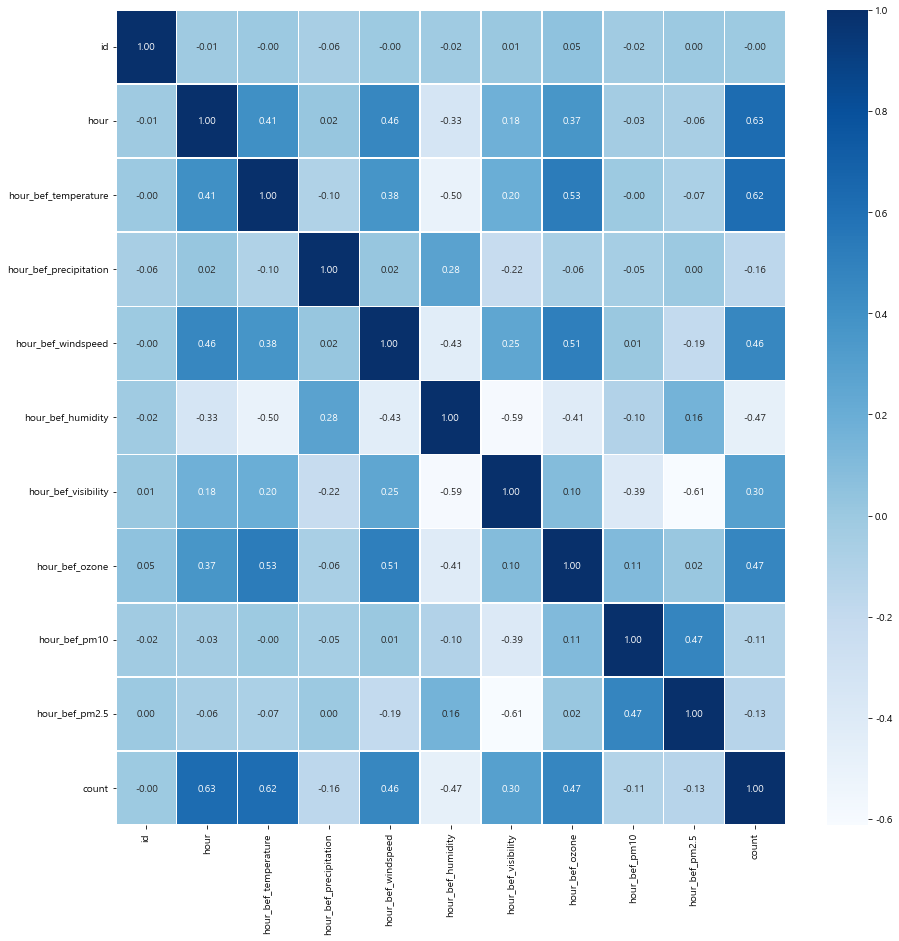

In [7]:
# 상관관계 확인을 위한 데이터 생성
feature = pd.concat([train, train_y], axis=1)

# 그래프를 통하여 확인
plt.figure(figsize=(15,15))
sns.heatmap(data = feature.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [8]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train, train_y, test_size=0.2, random_state=0)

In [9]:
# 모델 선언
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)

# fitting
random_forest.fit(x_train, y_train)

# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest RMSE: {np.sqrt(mean_squared_error(y_valid, y_pred))}')

random_forest RMSE: 37.099074924773696


- 통계적 수치활용 - clip
>- 데이터에서 설정한 값(0.05,0.95)보다 작은 값들을 설정한 값으로 대체
>- x.quantile의 값을 조정해서 사분위수로 이상치 제거하는 것도 가능함

In [10]:
# 데이터를 복사하여 실험을 진행
train_clip = train.copy()

# id를 제외한 데이터에 적용
train_clip.iloc[:,1:] = train_clip.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

In [11]:
# 이상치를 처리한 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train_clip, train_y, test_size=0.2, random_state=0)

### 실험결과의 성능을 확인 -> 결과만 봤을때 좋지는 않음
# pred
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_valid)
# 확인
print(f'random_forest RMSE: {np.sqrt(mean_squared_error(y_valid, y_pred))}')

random_forest RMSE: 38.5250783514622


- permutation importance를 활용하여 label을 예측하는데 가장 중요한 변수를 찾음

In [12]:
import eli5 
from eli5.sklearn import PermutationImportance

In [20]:
# permutation importance 
# 검증할 모델설정
model = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(x_train, y_train)
# permutation importance 확인
perm = PermutationImportance(model, random_state = 0).fit(x_valid, y_valid) 
eli5.show_weights(perm,top=40, feature_names = x_valid.columns.tolist())

Weight,Feature
0.8237 ± 0.1837,hour
0.3554 ± 0.0869,hour_bef_temperature
0.0331 ± 0.0100,hour_bef_humidity
0.0323 ± 0.0065,hour_bef_visibility
0.0307 ± 0.0058,hour_bef_ozone
0.0226 ± 0.0061,hour_bef_pm10
0.0217 ± 0.0056,hour_bef_precipitation
0.0104 ± 0.0062,hour_bef_pm2.5
0.0031 ± 0.0028,hour_bef_windspeed
-0.0119 ± 0.0089,id
